# Warm little pond model

This based on the model developed by Ben K. D. Pearce et al. in the following publications:

- Pearce, B. K., Pudritz, R. E., Semenov, D. A., & Henning, T. K. 2017, Proceedings of the National Academy of Sciences, 114, 11327
- Pearce, B. K. D., He, C., & Hörst, S. M. 2022, ACS Earth and Space Chemistry, 6, 2385
- Pearce, B. K. D., Hörst, S. M., Sebree, J. A., & He, C. 2024, The Planetary Science Journal, 5, 23

The original code can be found here: https://github.com/bennski/Wet_Dry_Cycling_Pond_Model. The original was modified to be more modular, making it easier to consider new molecules, consider new regimes for wet-dry cycling and add new source/sink terms. 

# Overview
Four regimes exist as a combination of a hydrological cycle and exogenous source:
- IDN + Met
- IDN + IDP
- COL + Met
- COL + IDP 

The terms are abbreviated as follows: 
- IDN (Intermediate drying)
- COL (continuous wet), these have different mean annual precipitation and seasonal amplitudes
- Met (meteorite source)
- IDP (Interplanetary Dust Particle source), these have different survival fractions

## Additions in progress
- attentuation of UV with depth?
- addition of atmospheric urea as a source based on detection on Earth? - minor
- addition of urea formation by gamma irradiation of clay: https://pubs.acs.org/doi/pdf/10.1021/acs.jpcb.0c05233 
- if urea is the only source of nulceobases (menor-salvan scenario), are nucleobase/urea concentrations stable?  - at what wavelength was this done? i.e. track nucleobase products from urea over time or the mystery product from the experiment??
- adjust UV flux to the specific star/planet


# Importing modules

In [4]:
import pylab as plb
import scipy as sy
import matplotlib.pyplot as plt
from scipy.optimize import leastsq
import numpy as np
import math
import csv

# Initialise

In [6]:
# Photolysis in wet phase
photo_wet = False

# Estimate loss due to chemistry
chemistry_on = True

# Wet-dry cycling? turns off evaporation, precipitation, and seepage
constant_water_level=True
evaporation_only=False # alternative to constant water level

## Photodissociation in the dry state
## Pearce et al early earth 3.9 Ga: 
F = 0.4               # UV flux between 200-250 nm incident on the entire pond area [W/m^2] ### probably meant to say per surface area
lambda_uv = 225e-9    # average wavelength of UV radiation incident on sample [m]

## M dwarf star photodissociation dry state
# F = 5e-5 # approx value from figure below
# F = 5e-3 
# lambda_uv = 225e-9

## Incoming organics
w_i_IDP = 60.7e-9     # Mass fraction of organics in incoming interplanetary dust (IDP)
m_dot_IDP = 6e8       # IPD mass flux to Earth [kg/yr]
f_s_IDP = 0.06        # Fraction of surviving organics during entry IDPs
f_s_Met = 0.32        # Survival fraction Met


R_plus = 6371000      # planet radius (Earth) in meters # impacts HCN rainout value?

## HCN Rain out into pond - used to estimate aqueous production of organics form HCN 
## currently not done per time step but at the end to set the initial concentration in the plot? 
# Mass influx from rain-out, data gathered from ChemKM non-equilibrium atmospheric models
HCN_mass_influx_ox = 3.42599458e-12 # kg/m2/s
HCN_mass_influx_red = 1.25776186e-07 # kg/m2/s

## HCN rain out M dwarf - estimate from Rimmer & Rugheimer surface mixing ratio (0.05 ppm in ox and 1 ppm in red) and deposition velocity of 0.01 cm/s
# HCN_mass_influx_ox = 5.84e-12 # kg/m2/s
# HCN_mass_influx_red = 1.12e-09 # kg/m2/s

###################################

### Initial conditions and time grid
# original tmax = 8 years and level = 16
tmax = 8 # years
level = 16
nt = (2**level) + 1 # Choosing nt to have twice as many grid points as nx
# Array for plotting
t = np.linspace(0,tmax,nt)
# Calculate delta_t - time step
delta_t = t[2] - t[1]

Rugheimer 2015 paper <br>
S. Rugheimer et al 2015 ApJ 806 137 (doi: 10.1088/0004-637X/806/1/137) <br>
Used to approximate the integrated UV flux from 200-250 nm <br>
Figure 5 

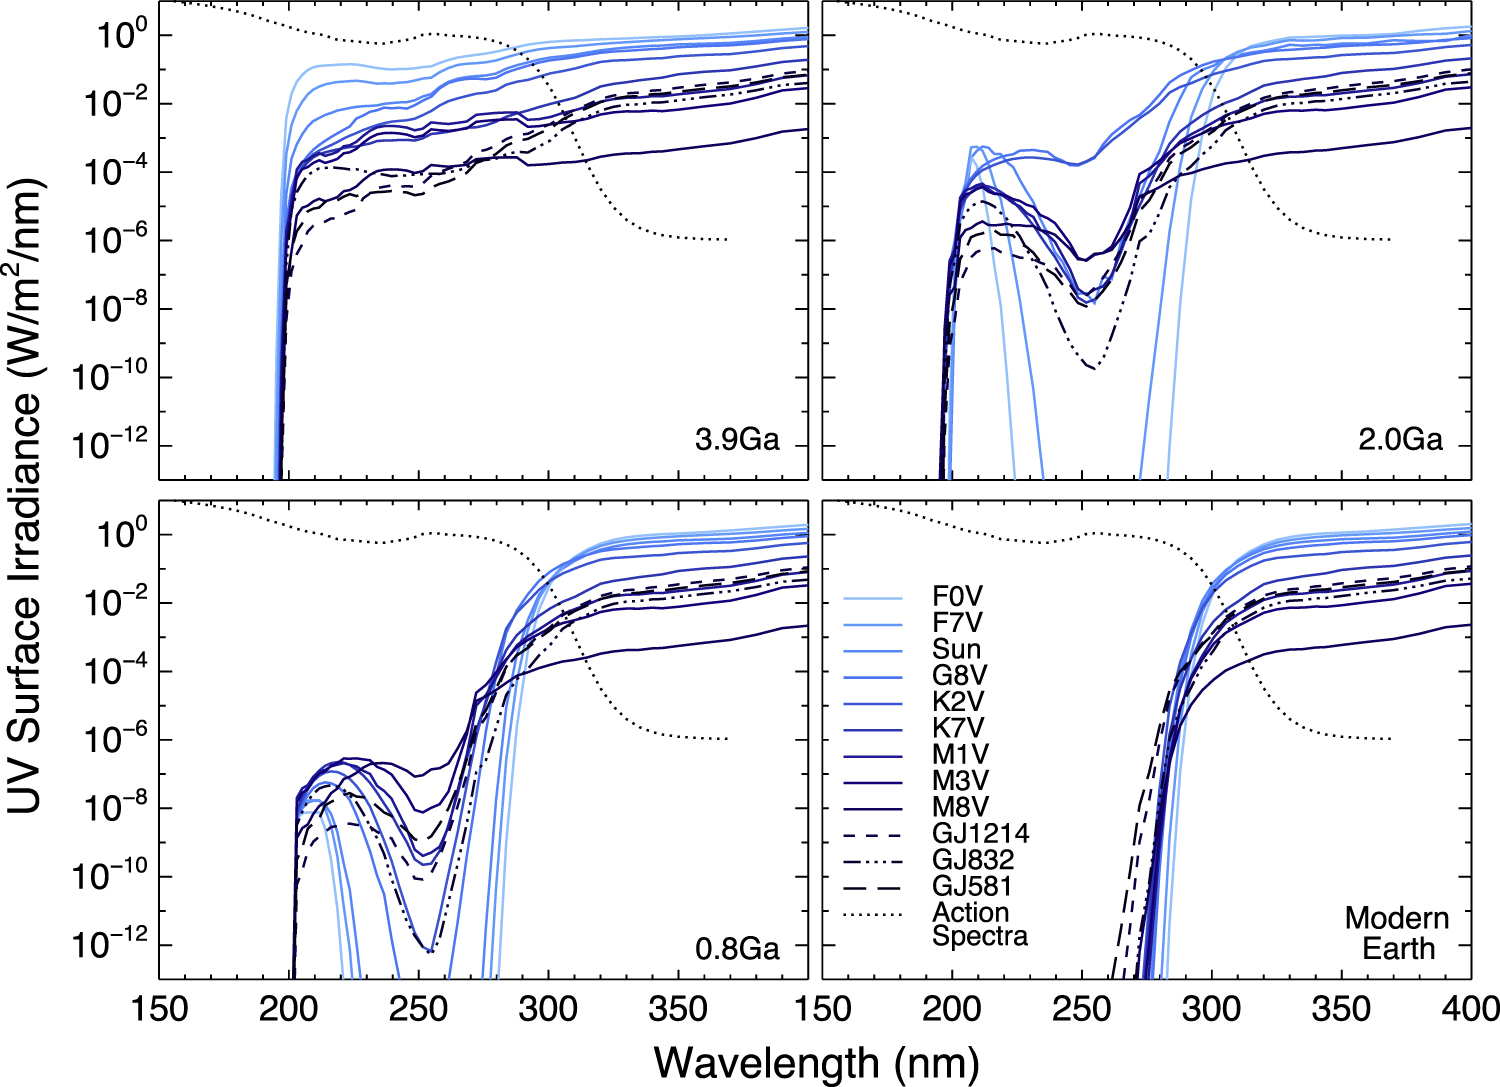

In [9]:
# load in molecules and their properties from csv file. 
molecules = {}

# with open('molecules.csv', 'r') as csvfile:
with open('molecules_adenine_urea_only.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        name = row['name']
        molecules[name] = {
            'mu': float(row['mu_kg/mol']),
            'rho': float(row['rho_kg/m3']),
            'Ea': float(row['Ea_hydro']),
            'B': float(row['B_hydro']),
            'k_photo': float(row['k_photo']),
            'yield_lo': float(row['yield_lo']),
            'yield_hi': float(row['yield_hi']),
            'quan_eff': float(row['quan_eff']),
            'Ea_chem': float(row['Ea_chem']),
            'B_chem': float(row['B_chem'])
        }
        
# mu : molecular mass in kg/mol
# rho : mass denisty in kgm-3
# Ea : activation parameter in K 
### from the following form:  log10(k) = -Ea/T + B 
# B : pre-exponential in arrhenius equation (dimensionless)
# k_photo : photolysis rate constant for aqueous phase in hr-1
# yields : min and max yields for molecule production from HCN
# quan_eff : quantum efficiency of photodissociation in molecules per photon 
### Adenine value from Pearce et al used for all molecules (as in their paper) except urea
### Urea value from thorgersen et al [doi.org/10.1002/chem.202400728]

## Defining variables, model parameters and molecule properties

In [11]:
### Variable Declarations
r_m = 40.             # Meteorite radius upon atmospheric entry [m]
rho = 2185.           # Density of meteorite fragments [kg/m^3]
r_p = 1.              # Pond radius [m]
A_p = math.pi*r_p**2  # Pond surface area [m^2]
r_g = 500.            # Debris radius after meteoroid impact [m]

# Diffusion time constant from meteorite fragments based on Pearce 2017 calculation (see supplementary)
tau_d_1cm = 4.9e-3    # [yr] - used by Pearce et al in 2022 and 2024.
# tau_d_5cm = 0.12    # [yr]
# tau_d_10cm = 0.48   # [yr]

gamma = 31557600      # Seconds per year
rho_w = 1000.         # Water density [kg/m^3]

### Precipitation Models
# IDN is for intermediate drying: six months wet, six months dry
# COL is for continuous wet, minor fluctuations
tau_s = 1.0         # Seasonal period [yr]
# P_CAM = 3.5         # Precipitation rate [m/yr] for model
P_IDN = 4.5         
P_COL = 6.
# delta_CAM = 0.5     # Seasonal amplitude of precipitation - how much rainfall varies/oscillates seasonally
delta_IDN = 0.2
delta_COL = 0.5
# sp_CAM = 0.3        # Seasonal phase shift - align sinusoidal cycle to calendar year
sp_IDN = 0.85
sp_COL = 0.3

min_water = 0.001     # Minimum pond water depth [m] i.e. 1 mm 
S = 0.95              # Seepage rate 0.36525 (fraction water lost per year)

# Constants
h = 6.626e-34         # Planck’s constant [J·s]
c = 2.9979e8          # Speed of light [m/s]
N_A = 6.022e23        # Avogadro's number

E_65 = (S-0.12+0.06*65) # Evaporation rate and seepage rate at 65 C
m_seepage_rate = math.pi*rho_w*r_p**2*S # Constant seepage mass per year
m_i0 = (4./3)*w_i_IDP*f_s_Met*r_m**3*rho*A_p/r_g**2 # total specie i mass deposited into WLP from meteorite

if constant_water_level:
    P_IDN = 0
    P_COL = 0
    E_65 = 0
    m_seepage_rate=0
if evaporation_only:
    P_IDN = 0
    P_COL = 0
    E_65=-0.12+0.06*65
    m_seepage_rate=0

## Calculation of additional molecule parameters

In [13]:
for mm in molecules:
    mu=molecules[mm]["mu"]
    rho=molecules[mm]["rho"]
    Ea=molecules[mm]["Ea"] # hydrolysis
    B=molecules[mm]["B"] # hydrolysis
    T=273.15+65
    Phi=molecules[mm]['quan_eff']
    Ea_chem=molecules[mm]["Ea_chem"]
    B_chem=molecules[mm]["B_chem"]
    
    # calculating additional parameters
    M_uv_dot=((Phi*F*lambda_uv*gamma*mu)/(h*c*N_A)) # photolysis when dry
    diameter=2*(3*mu/(4*math.pi*N_A*rho))**(1./3) if rho>0 else 0
    k_hydrolysis=10**(-Ea/T + B) # hydrolysis rate in wet state
    k_chem=10**(-Ea_chem/T + B_chem) # estimate for loss due to chemistry upon cycling
    m_dot_ox=(HCN_mass_influx_ox*4*math.pi*R_plus**2)*(mu/molecules['HCN']['mu'])  # influx HCN over pond area reblanced using molecule mu in oxidising state
    m_dot_red=(HCN_mass_influx_red*4*math.pi*R_plus**2)*(mu/molecules['HCN']['mu']) # HCN influx in reducing state
    m_dot=m_dot_IDP*f_s_IDP*w_i_IDP
    
    # updating dicitonary
    molecules[mm].update({'M_uv_dot' : M_uv_dot})
    molecules[mm].update({'d' : diameter})
    molecules[mm].update({'k_hydrolysis' : k_hydrolysis})
    molecules[mm].update({'m_dot' : m_dot})
    molecules[mm].update({'m_dot_ox' : m_dot_ox})
    molecules[mm].update({'m_dot_red' : m_dot_red})
    molecules[mm].update({'k_chem':k_chem})

In [14]:
print(molecules['Urea'])

{'mu': 0.06006, 'rho': 1335.0, 'Ea': 9640.0, 'B': 12.1, 'k_photo': 0.2362, 'yield_lo': 0.05, 'yield_hi': 0.16, 'quan_eff': 0.54, 'Ea_chem': 9000.0, 'B_chem': 20.83, 'M_uv_dot': 0.7700452377366626, 'd': 5.225424328094758e-10, 'k_hydrolysis': 3.9078820409238914e-17, 'm_dot': 2.1851999999999996, 'm_dot_ox': 3883.528976913582, 'm_dot_red': 142573332.07359374, 'k_chem': 1.6390516389644798e-06}


## Defining functions

- Defining function that update pond water level according to different precipitation models
- Defining function that uses the updated water level to calculate the mass of a molecule

In [16]:
def update_molecule_mass(n, mm, model, dry):
    m_arr=results[model][mm]['mass']
    m_prev=m_arr[n]
    m_water_prev=pond_charac[model]['mass'][n]
    
    rho=molecules[mm]["rho"]
    d=molecules[mm]["d"]
    M_uv_dot=molecules[mm]["M_uv_dot"]
    k_hydro=molecules[mm]["k_hydrolysis"]
    k_chem=molecules[mm]["k_chem"]
    
    if 'ox' in model:
        m_dot=molecules[mm]['m_dot_ox']
    elif 'red' in model:
        m_dot=molecules[mm]['m_dot_red']
    else:
        m_dot=molecules[mm]['m_dot']

    mol_area=m_prev/(rho*d)
    add_flux=(delta_t*m_dot*A_p)/(4*np.pi*R_plus**2)
    
    if dry: # pond dry regime
        if mol_area<A_p: # mass limited dissociation
            loss_uv=delta_t*M_uv_dot*m_prev/(rho*d)
        else: # area limited
            loss_uv=delta_t*M_uv_dot*A_p
            
        m_next=m_prev+add_flux-loss_uv
    else: # pond wet regime
        if photo_wet: # aqueous phase photodissociation
            k_photo_yr=molecules[mm]['k_photo']*365*24 # conversion from hr-1 to yr-1 
        else: 
            k_photo_yr=0
            
        if chemistry_on: # aqueous phase chemistry
            chem_loss=delta_t*gamma*k_chem*m_prev if k_chem>0 else 0
        else:
            chem_loss=0
        
        seepage_loss=delta_t*m_prev*m_seepage_rate/m_water_prev
        hydrolysis_loss=delta_t*gamma*k_hydro*m_prev if k_hydro>0 else 0
        photolysis_term=delta_t*k_photo_yr*m_prev
        
        m_next=m_prev+add_flux-seepage_loss-hydrolysis_loss-photolysis_term-chem_loss

    return max(m_next, 0)

def update_pond_level(L_prev, t_now, is_IDN):
    if is_IDN:
        seasonal_factor=1+delta_IDN*np.sin(2*math.pi*(t_now-sp_IDN)/tau_s)
        L_new=L_prev+E_65*delta_t-delta_t*P_IDN*seasonal_factor
    else:
        seasonal_factor=1+delta_COL*np.sin(2*math.pi*(t_now-sp_COL)/tau_s)
        L_new=L_prev+E_65*delta_t-delta_t*P_COL*seasonal_factor

    L_new=max(min(L_new, r_p-min_water),0)
    return L_new

def update_met_mass(mm, L_new, m_prev, m_water_prev, pause, is_IDN): # NO aqueous production and NO chemistry loss
    rho_i=molecules[mm]['rho']
    d=molecules[mm]['d']
    M_uv_dot=molecules[mm]['M_uv_dot']
    k_hydro=molecules[mm]['k_hydrolysis']
    k_chem=molecules[mm]["k_chem"]
    
    if L_new>=(r_p-min_water):  # Pond dry
        L_new=r_p-min_water
        # UV-driven loss
        if m_prev/(rho_i*d)<A_p: # mass limited
            m_new=m_prev-delta_t*M_uv_dot*m_prev/(rho_i*d)
        else: # area limited
            m_new=m_prev-delta_t*M_uv_dot*A_p
        pause+=1
        
    else:  # Pond wet
        if photo_wet: # aqueous phase photodissociation
            k_photo_yr=molecules[mm]['k_photo']*365*24 # conversion from hr-1 to yr-1 
        else: 
            k_photo_yr=0
        if chemistry_on: # aqueous phase chemistry
            chem_loss=delta_t*gamma*k_chem*m_prev if k_chem>0 else 0
        else:
            chem_loss=0
           
        decay_factor=np.exp(-t[n-pause]*(gamma*k_hydro+(1./tau_d_1cm)))
        input_term=delta_t*m_i0*decay_factor/tau_d_1cm # input of molecule from meteorite (exponential decay with time)
        hydrolysis_term=delta_t*gamma*k_hydro*m_prev # destruction 
        seepage_term=delta_t*m_prev*m_seepage_rate/m_water_prev # loss 
        photolysis_term=delta_t*k_photo_yr*m_prev # destruction by radiation
        
        m_new=m_prev+input_term-hydrolysis_term-seepage_term-photolysis_term-chem_loss
    return max(m_new,0), pause

def update_water_mass(L_new):
    return math.pi*rho_w*(r_p**2)*(r_p-L_new)

## Initialising arrays for storage 

In [18]:
# Creating arrays for storage
model_names=['IDN_Met', 'COL_Met','IDN_IDP', 'IDN_IDP_red', 'IDN_IDP_ox', 'COL_IDP_red']
results={model: {mm: {'mass': np.zeros(nt), 'pause' : 0, 'concentration' : np.zeros(nt)} for mm in molecules} for model in model_names}
pond_charac={model: {'level': np.zeros(nt), 'mass': np.zeros(nt)} for model in model_names}

# Set initial water levels and mass
for model in model_names:
    if constant_water_level or evaporation_only:
        pond_charac[model]['level'][0]=0.0 # pond starts full (level is measure of how empty it is)
    else:
        pond_charac[model]['level'][0]=r_p-min_water # pond starts empty
    pond_charac[model]['mass'][0]=update_water_mass(pond_charac[model]['level'][0])

# Set initial biomolecule masses
for model in model_names:
    for mm in molecules:
        results[model][mm]['mass'][0]=0.0  
        results[model][mm]['concentration'][0]=0.0  

# Modelling
## Met Model
The Meteorite (Met) source model for intermediate and continuous precipitation. 

In [20]:
for n in range(nt-1):
    # --- IDN Model ---
    # determine new water level
    L_IDN_new=update_pond_level(pond_charac['IDN_Met']['level'][n], t[n], is_IDN=True)
    if L_IDN_new>=(r_p-min_water):
        L_IDN_new=r_p-min_water
    pond_charac['IDN_Met']['level'][n+1]=L_IDN_new
    # determine new water level
    pond_charac['IDN_Met']['mass'][n]=update_water_mass(L_IDN_new)
    
    # determine new molecule mass
    for molec in molecules: 
        pause_IDN=results['IDN_Met'][molec]['pause']
        m_mol_prev_IDN_Met=results['IDN_Met'][molec]['mass'][n]
        # calculate new mass and count pause (level zero)
        m_new_IDN_Met, pause_IDN=update_met_mass(molec, L_IDN_new, m_mol_prev_IDN_Met, pond_charac['IDN_Met']['mass'][n], pause_IDN, is_IDN=True)
        results['IDN_Met'][molec]['mass'][n+1]=m_new_IDN_Met
        results['IDN_Met'][molec]['pause']=pause_IDN 
    
    ##### COL Model #####
    # new water level
    L_COL_new=update_pond_level(pond_charac['COL_Met']['level'][n], t[n], is_IDN=False)
    if L_COL_new>=(r_p-min_water):
        L_COL_new=r_p-min_water
    pond_charac['COL_Met']['level'][n+1]=L_COL_new
    # new water mass
    pond_charac['COL_Met']['mass'][n]=update_water_mass(L_COL_new)
    
    for molec in molecules:
        pause=results['COL_Met'][molec]['pause']
        m_molprev_COL_Met=results['COL_Met'][molec]['mass'][n]
    
        m_new_COL_Met, pause=update_met_mass(molec, L_COL_new, m_molprev_COL_Met, pond_charac['COL_Met']['mass'][n], pause, is_IDN=False)
    
        results['COL_Met'][molec]['mass'][n+1]=m_new_COL_Met
        results['COL_Met'][molec]['pause']=pause

## IDP model
Interplanetary Dust (IDP) source model and aqeuous production <br>
Also for continuous and intermediate precipitation. Aqueous production based on HCN influx from the atmosphere is included. 

In [22]:
for n in range(nt-1):
    for model in model_names:
        if 'IDP' in model:
            is_IDN=model.startswith("IDN")
            t_now=t[n]
            # Update pond level
            L_prev=pond_charac[model]['level'][n]
            L_new=update_pond_level(L_prev, t_now, is_IDN)
            pond_charac[model]['level'][n+1]=L_new
            # Check if pond is dry
            dry=L_new>=(r_p-min_water)
            if dry:
                L_new=r_p-min_water
                pond_charac[model]['level'][n+1]=L_new
            # Update water mass
            m_water=update_water_mass(L_new)
            pond_charac[model]['mass'][n+1]=m_water
            # Update molecules
            for mm in molecules:
                results[model][mm]['mass'][n+1]=update_molecule_mass(n, mm, model, dry)

C:\Users\vikki\AppData\Local\Temp\ipykernel_34052\769667045.py:19: RuntimeWarning: invalid value encountered in scalar divide
  mol_area=m_prev/(rho*d)
C:\Users\vikki\AppData\Local\Temp\ipykernel_34052\769667045.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  mol_area=m_prev/(rho*d)


Calculate molecule concentrations in pond

In [24]:
for n in range(nt-1):
    for model in model_names:
        m_water=pond_charac[model]['mass'][n+1]
        for mm in molecules:
            m_bio=results[model][mm]['mass'][n+1]
            if m_water>0:
                results[model][mm]['concentration'][n+1]=m_bio/m_water
            else:
                results[model][mm]['concentration'][n+1]=0.0

# Plotting
## Original plotting functions
Use to check that output is the same as in the orignal work, set molec to 'Adenine' and compare to the original figure in Pearce et al 2022

In [26]:
# Plot molecule
molec = "Urea"
figure_details = 'earlyearth_photolysisoff_chemon_constantlevel'

In [27]:
# Reassign concentration arrays for molec
C_IDN_IDP           = results['IDN_IDP'][molec]['concentration']
C_COL_IDP           = results['COL_IDP_red'][molec]['concentration']
C_IDN_Met           = results['IDN_Met'][molec]['concentration']
C_COL_Met           = results['COL_Met'][molec]['concentration']
C_IDN_red           = results['IDN_IDP_red'][molec]['concentration']
C_COL_red           = results['COL_IDP_red'][molec]['concentration']
C_IDN_ox            = results['IDN_IDP_ox'][molec]['concentration']
exp_upper           = molecules[molec]['yield_hi']
exp_lower           = molecules[molec]['yield_lo']

mu_molec = molecules[molec]['mu']

#Conversion from molar to mass mixing ratios
def molar2mass(x):
    return x*1.e3*mu_molec
def mass2molar(x):
    return x/1.e3/mu_molec

Original plotting

<Figure size 640x480 with 0 Axes>

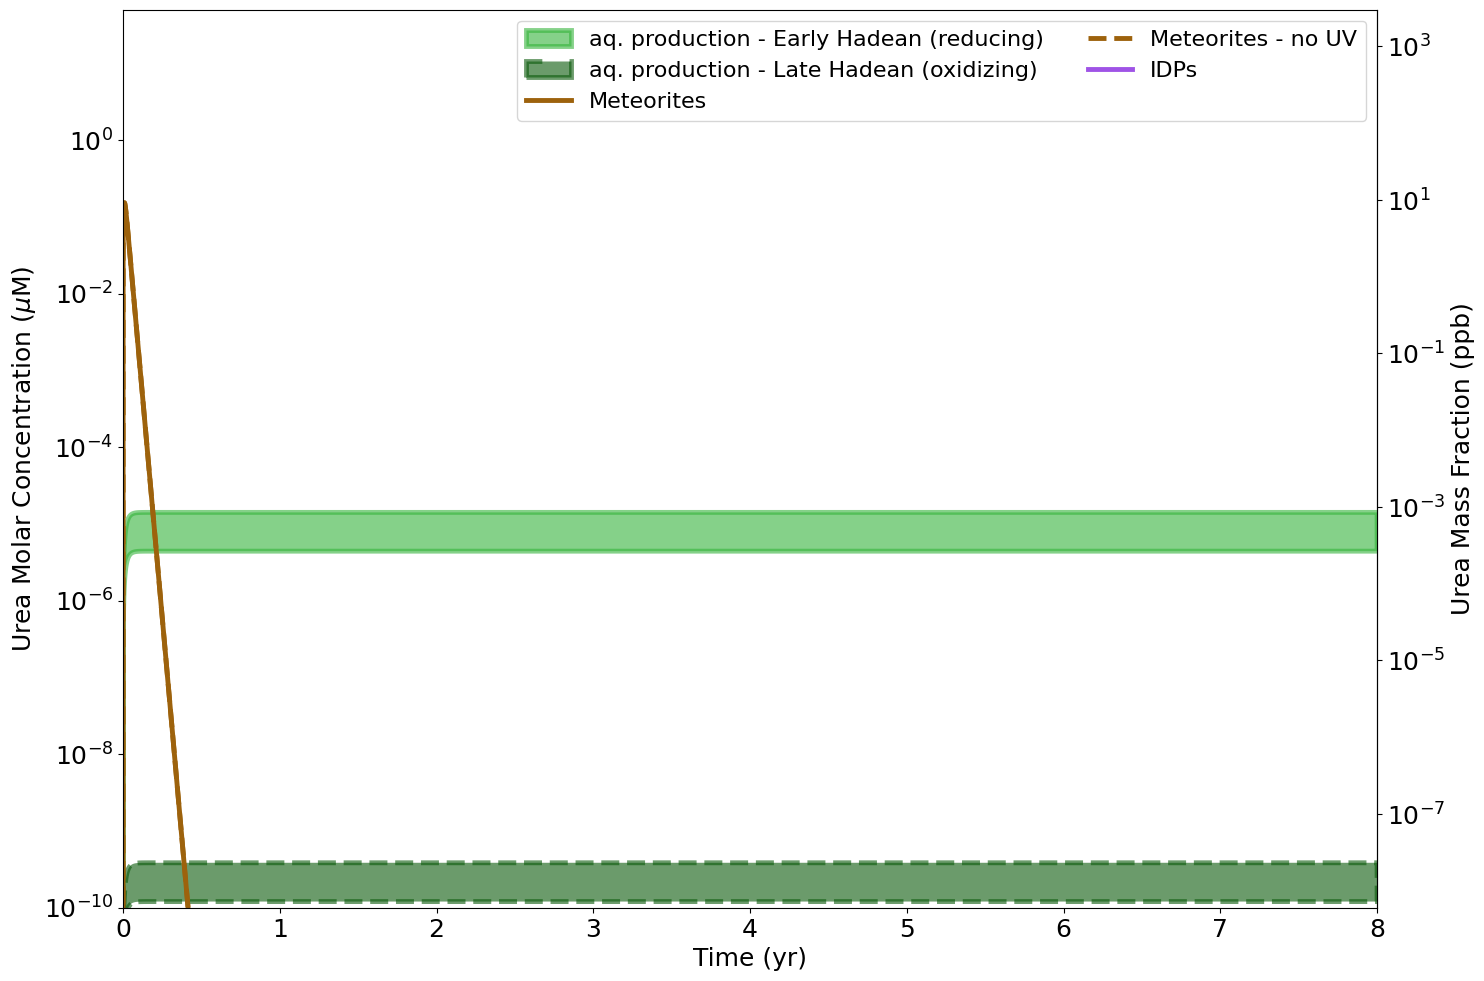

In [29]:
plt.clf()
f, ax1 = plt.subplots(1, 1, figsize=(15,10))
        
p1 = ax1.fill_between(t, C_IDN_red*exp_lower*1e6/mu_molec, C_IDN_red*exp_upper*1e6/mu_molec, linestyle='-', color='#34b33a', lw=3.5, label=r'$\it{in}$ $\it{situ}$ Production - Early Hadean (reducing)', alpha=.60)       
p2, = ax1.plot(t, C_IDN_Met*1e6/mu_molec, linestyle='-', color='#9d620c', lw=3.5, label='Meteorites - Intermediate Env.')
p3, = ax1.plot(t, C_IDN_IDP*1e6/mu_molec, linestyle='-', color='#9f53e6', lw=3.5, label='IDPs - Intermediate Env.')  
p4 = ax1.fill_between(t, C_IDN_ox*exp_lower*1e6/mu_molec, C_IDN_ox*exp_upper*1e6/mu_molec, linestyle='--', color='#095909', lw=3.5, label=r'$\it{in}$ $\it{situ}$ Production - Late Hadean (oxidizing)', alpha=.60)
p5, = ax1.plot(t, C_COL_Met*1e6/mu_molec, linestyle='--', color='#9d620c', lw=3.5, label='Meteorites - Wet Env.')      

secax = ax1.secondary_yaxis('right', functions=(molar2mass, mass2molar))
secax.set_ylabel(f"{molec} Mass Fraction (ppb)",fontsize=18)
#secax.set_yticklabels([1e-7,1e-5,1e-3,1e-1,1e1,1e3],fontsize=18)

ax1.set_ylim(1e-10,50.)
ax1.set_xlim(0,8)

# added labels to points in the curve
# ax1.text(0.222, 0.742, "1", ha="center", size=14, transform=ax1.transAxes, bbox=dict(boxstyle="circle", fc="w", ec="k"))
# ax1.text(0.247, 0.702, "2", ha="center", size=14, transform=ax1.transAxes, bbox=dict(boxstyle="circle", fc="w", ec="k"))
# ax1.text(0.288, 0.647, "3", ha="center", size=14, transform=ax1.transAxes, bbox=dict(boxstyle="circle", fc="w", ec="k"))

ax1.legend([p1,p4,p2,p5,p3], [r'aq. production - Early Hadean (reducing)', r'aq. production - Late Hadean (oxidizing)','Meteorites', 'Meteorites - no UV', 'IDPs',r'Organic Hazes (Early Hadean, 0.5% CH$_4$)'], loc=1,ncol=2, fontsize=16)
ax1.set_yscale('log')

# for tick in ax1.yaxis.get_major_ticks()[::2]:
   # tick.set_visible(False)
ax1.set_xlabel('Time (yr)', fontsize=18)
ax1.set_ylabel(f'{molec} Molar Concentration ($\mu$M)', fontsize=18)
for tick in ax1.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
    
secax.tick_params(axis='both',labelsize=18)

ax1.text(-1.25, 1.7e1,'', fontsize=30, weight='bold', color='black')

plt.tight_layout()
plt.savefig(f'figures/{molec}_{figure_details}.png',dpi=300)

The Pearce et al Figure 4 from:- Toward RNA Life on Early Earth: From Atmospheric HCN to Biomolecule Production in Warm Little Ponds

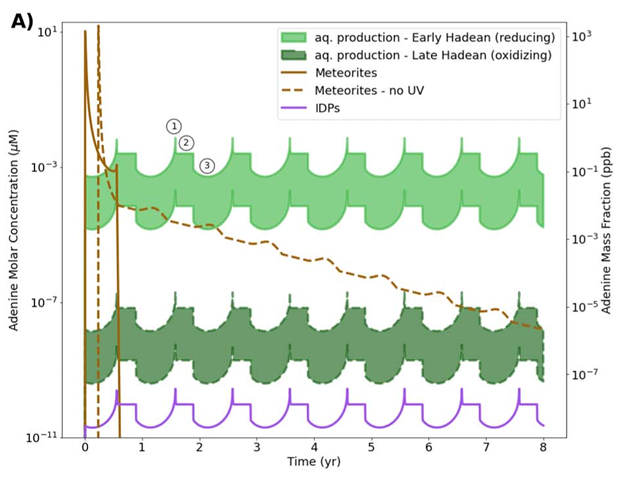

## Water level over time


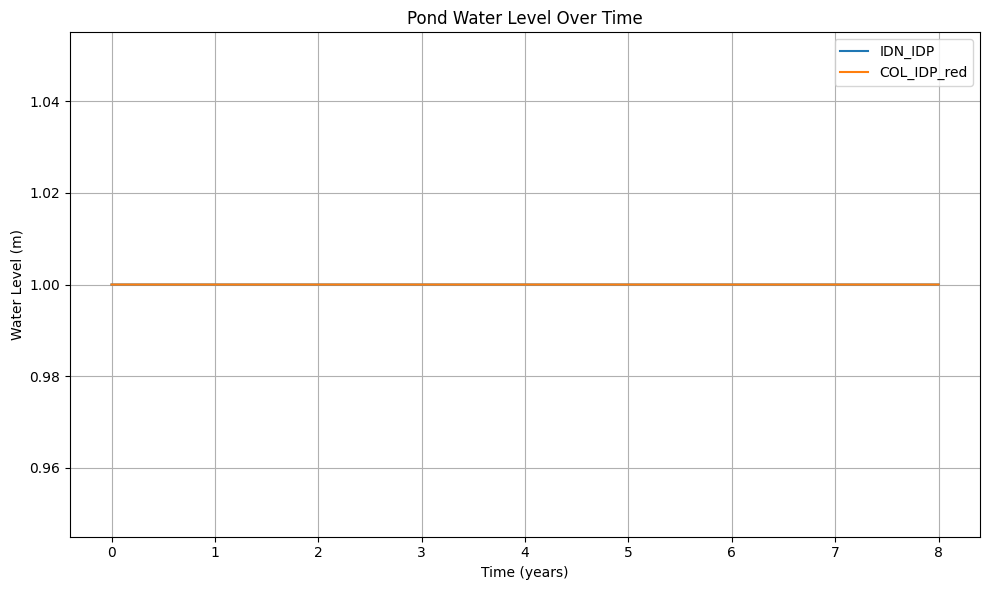

In [33]:
# models = ['IDN_Met', 'COL_Met','IDN_IDP', 'IDN_IDP_red', 'IDN_IDP_ox', 'COL_IDP_red']
# models=['IDN_Met', 'COL_Met']
models=['IDN_IDP','COL_IDP_red']

plt.figure(figsize=(10, 6))

for model in models:
    wl = 1-pond_charac[model]['level'] # since level is really a measure of emptiness
    plt.plot(t, wl, label=model)

plt.xlabel('Time (years)')
plt.ylabel('Water Level (m)')
plt.title('Pond Water Level Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()